# 백 테스터 예제 만들기

2018년 1월 1일부터 2019년 1월 1일까지의 기간에서
1) 삼성전자 주식은 매달 1일에 사서 다음달 1일에 매도 한다.
2) 삼성전기 주식을 매달 2일에 사서 다음달 2일에 매도 한다.

구할 것 : 
1. Order_list를 만든다.
2. Portfolio 내 종목 이름, 종목 수 변화, 전체 가치, 수익률 변화

기본 데이터 : 
삼성전자 1년치 데이터
삼성전기 1년치 데이터

In [1]:
import pandas as pd
import requests
import json
from datetime import datetime, timedelta
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import Stockprice_getter

In [3]:
priceobj = Stockprice_getter.Stockprice_getter()

주식 크롤러 작동
OTP정보 로드 중
OTP정보 로드 완료


In [4]:
code_list = priceobj.code_list
otp = priceobj.otp
header = priceobj.header

In [5]:
%matplotlib inline

In [6]:
A066570 = priceobj.get_stock_price('A066570', '20180101', '20190101')
A009150 = priceobj.get_stock_price('A009150', '20180101', '20190101')

In [7]:
A066570

,trd_dd,tdd_clsprc,fluc_tp,tdd_cmpr,acc_trdvol,acc_trdval,tdd_opnprc,tdd_hgprc,tdd_lwprc,mktcap,list_shrs,short_code,codeName
0,2018-01-02,109500,1,"3,500","948,226","103,093,671,000","106,500","111,000","105,500","17,919,436","163,647,814",A066570,LG전자
1,2018-01-03,109500,3,0,"627,983","68,386,930,786","109,500","110,500","107,500","17,919,436","163,647,814",A066570,LG전자
2,2018-01-04,106000,2,"3,500","977,691","104,959,413,400","110,500","111,000","105,000","17,346,668","163,647,814",A066570,LG전자
3,2018-01-05,111000,1,"5,000","883,832","97,229,450,500","106,000","111,500","106,000","18,164,907","163,647,814",A066570,LG전자
4,2018-01-08,105000,2,"6,000","2,480,029","264,241,769,000","113,500","114,000","103,500","17,183,020","163,647,814",A066570,LG전자
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2018-12-21,62400,2,200,"829,833","51,736,980,600","62,000","62,900","61,800","10,211,624","163,647,814",A066570,LG전자
240,2018-12-24,61800,2,600,"513,348","31,731,223,900","62,000","62,400","61,200","10,113,435","163,647,814",A066570,LG전자
241,2018-12-26,61300,2,500,"453,037","27,737,578,100","61,000","61,900","60,600","10,031,611","163,647,814",A066570,LG전자
242,2018-12-27,61900,1,600,"562,848","35,158,643,900","62,500","63,300","61,700","10,129,800","163,647,814",A066570,LG전자


In [8]:
order = pd.DataFrame(index = A066570['trd_dd'])

elec_buy = []
for i in range(1,13):
    for date in order.index[::-1]:    
        if date.month == i:
            elec_buy.append(date)
            break

mecha_buy = []
for i in range(1,13):
    for date in order.index:    
        if date.month == i:
            mecha_buy.append(date)
            break          

order['A066570'] = 0
for idx, day in enumerate(elec_buy):   
    order.loc[day, 'A066570'] = idx+1

order['A009150'] = 0
for idx, day in enumerate(mecha_buy):   
    order.loc[day, 'A009150'] = idx+1

order.sort_values(['trd_dd'], inplace=True)
order.index.rename('date', inplace = True)
order

,A066570,A009150
date,,
2018-01-02,0,1
2018-01-03,0,0
2018-01-04,0,0
2018-01-05,0,0
2018-01-08,0,0
...,...,...
2018-12-21,0,0
2018-12-24,0,0
2018-12-26,0,0


In [9]:
data = {'A066570' : A066570, 'A009150' : A009150}

In [10]:
def get_cash_expense(order, data):
    order_tmp = order.copy()
    data_tmp = data.copy()
    close_price_list = []
    for code in order_tmp.columns:
        close_prices = list(data_tmp[code]['tdd_clsprc'])        
        close_price_list.append(close_prices)
    df_close = pd.DataFrame(close_price_list).T
    
        
    cash_expense = []
    for i in range(len(order_tmp)):
        stocks = np.array(order_tmp.iloc[i])
        prices = np.array(df_close.iloc[i])      
        cash = stocks.dot(prices)        
        cash_expense.append(cash)

    return pd.DataFrame(cash_expense, index = order.index, columns = ['cash_expense'])

In [11]:
get_cash_expense(order, data)

,cash_expense
date,
2018-01-02,101000
2018-01-03,0
2018-01-04,0
2018-01-05,0
2018-01-08,0
...,...
2018-12-21,0
2018-12-24,0
2018-12-26,0


In [196]:
def get_portfolio(order):
    order_tmp = order.copy()
    for col in order_tmp.columns:
        new = []
        for idx in range(len(order_tmp[col])):
            new.append(sum(order_tmp[col][:idx+1]))
        order_tmp[col] = new
    portfolio = order_tmp
    
    return portfolio

In [13]:
port = get_portfolio(order)

In [14]:
port

,A066570,A009150
date,,
2018-01-02,0,1
2018-01-03,0,1
2018-01-04,0,1
2018-01-05,0,1
2018-01-08,0,1
...,...,...
2018-12-21,66,78
2018-12-24,66,78
2018-12-26,66,78


In [15]:
def get_portfolio_value(order, data):
    portfolio = get_portfolio(order)
    data_tmp = data.copy()
    close_price_list = []
    for code in portfolio.columns:
        close_prices = list(data_tmp[code]['tdd_clsprc'])        
        close_price_list.append(close_prices)
    df_close = pd.DataFrame(close_price_list).T
    
        
    value_list = []
    for i in range(len(portfolio)):
        stocks = np.array(portfolio.iloc[i])
        prices = np.array(df_close.iloc[i])      
        value = stocks.dot(prices)        
        value_list.append(value)

    return pd.DataFrame(value_list, index = order.index, columns = ['portfolio_value'])

In [16]:
portfolio_value = get_portfolio_value(order, data) ## Split과 같은 변동이 적용되지 않은 값들

In [17]:
portfolio_value

,portfolio_value
date,
2018-01-02,101000
2018-01-03,100000
2018-01-04,98800
2018-01-05,107000
2018-01-08,108500
...,...
2018-12-21,12191400
2018-12-24,11956800
2018-12-26,11728800


In [203]:
## 포트폴리오 수익률 구하기
def seq_mul(list_):
    base = 1
    for com in list_:
        base *= com
    return base
        

def get_porfolio_growth(order, data):
    order_tmp = order.copy()
    data_tmp = data.copy()
    portfolio_value = get_portfolio_value(order_tmp, data_tmp)
    shift1 = portfolio_value['portfolio_value'].shift(1)
    shift0 = portfolio_value['portfolio_value']
    portfolio_growth = pd.DataFrame(index = portfolio_value.index, columns = ['portfolio_growth'])
    for i in range(len(portfolio_value)):
        portfolio_growth.iloc[i,0] = shift0[i] / shift1[i]
    portfolio_growth = (portfolio_growth-1)*100
    
    return portfolio_growth


def get_stocks_return(order, data):
    order_tmp = order.copy()
    data_tmp = data.copy()
    
    return_code_list = []
    for code in order_tmp.columns:
        stock = data_tmp[code]
        return_stock = stock['tdd_clsprc']/stock['tdd_clsprc'].shift(1)
        return_stock = (return_stock-1) * 100
        return_code_list.append(return_stock)
        
    df_return = pd.DataFrame(return_code_list).T
    df_return.columns = order_tmp.columns
    df_return.index = order_tmp.index
    
    return df_return
    
    
def get_portfolio_return(order, data):    
    order_tmp = order.copy()
    data_tmp = data.copy()
    portfolio = get_portfolio(order_tmp)    
    df_return = get_stocks_return(order_tmp, data_tmp)
    
    wgt_return_list = [np.nan]
    for i in range(1, len(portfolio_value.index)):
        sum_stocks = np.array([portfolio.iloc[i]]).sum()
        wgt = np.array(portfolio.iloc[i]) / sum_stocks        
        returns = np.array(df_return.iloc[i])        
        wgt_return = wgt.dot(returns)
        wgt_return_list.append(wgt_return)    
    
        
    return pd.DataFrame(wgt_return_list, index = order_tmp.index, columns = ['wgt_return'])

In [194]:
get_porfolio_growth(order, data)

,portfolio_growth
date,
2018-01-02,NaN
2018-01-03,-0.990099
2018-01-04,-1.2
2018-01-05,8.2996
2018-01-08,1.40187
...,...
2018-12-21,-0.108156
2018-12-24,-1.92431
2018-12-26,-1.90686


In [157]:
get_stocks_return(order, data)

,A066570,A009150
date,,
2018-01-02,NaN,NaN
2018-01-03,0.000000,-0.990099
2018-01-04,-3.196347,-1.200000
2018-01-05,4.716981,8.299595
2018-01-08,-5.405405,1.401869
...,...,...
2018-12-21,-0.319489,0.000000
2018-12-24,-0.961538,-2.415459
2018-12-26,-0.809061,-2.475248


In [204]:
get_portfolio_return(order, data)

,wgt_return
date,
2018-01-02,NaN
2018-01-03,-0.990099
2018-01-04,-1.200000
2018-01-05,8.299595
2018-01-08,1.401869
...,...
2018-12-21,-0.146432
2018-12-24,-1.749079
2018-12-26,-1.711579


In [780]:
def istrade(row):
    checker = False
    for x in row:
        if x != 0:
            checker = True
            
    return checker

In [19]:
def get_irr_return(order,data):
    order_tmp = order.copy()
    data_tmp = data.copy()
    portfolio_value = get_portfolio_value(order_tmp,data_tmp)
    cash_expense = get_cash_expense(order_tmp,data_tmp)
    irr_list = []
    return_list = []
    for idx, val in enumerate(list(portfolio_value['portfolio_value'])):
        money = cash_expense['cash_expense'][idx]
        irr_list.append(-money)
        return_measure = np.irr(irr_list[:-1] + [irr_list[-1] + val])
        return_list.append(return_measure)
        
    return pd.DataFrame(return_list, index = order_tmp.index, columns=['irr_return'])


In [102]:
irr = get_irr_return(order,data)

C:\Users\dlcks\Anaconda3\envs\finance64\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: numpy.irr is deprecated and will be removed from NumPy 1.20. Use numpy_financial.irr instead (https://pypi.org/project/numpy-financial/).
  # This is added back by InteractiveShellApp.init_path()


In [103]:
x = irr + 1

In [104]:
x

,irr_return
date,
2018-01-02,NaN
2018-01-03,0.990099
2018-01-04,0.989049
2018-01-05,1.019422
2018-01-08,1.018069
...,...
2018-12-21,0.997015
2018-12-24,0.996810
2018-12-26,0.996610


In [105]:
a = []
for i in range(1,len(irr)):
    a.append(seq_mul(list(x['irr_return'])[1:i]))   

In [107]:
seq_mul(list(x['irr_return'])[1:1])

1

In [109]:
list(x['irr_return'])[1:2]

[0.9900990099009901]

In [78]:
type(np.nan)

float

In [112]:
def get_cum_return(order,data):
    order_tmp = order.copy()
    data_tmp = data.copy()
    irr = get_irr_return(order_tmp,data_tmp) + 1
    cum_return = [np.nan]
    for i in range(2,len(irr)+1):
        cum_return.append(seq_mul(list(irr['irr_return'])[1:i]))
        
    return pd.DataFrame(cum_return, index = order_tmp.index, columns = ['cum_return'])    

In [114]:
cum = get_cum_return(order,data)

C:\Users\dlcks\Anaconda3\envs\finance64\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: numpy.irr is deprecated and will be removed from NumPy 1.20. Use numpy_financial.irr instead (https://pypi.org/project/numpy-financial/).
  # This is added back by InteractiveShellApp.init_path()


C:\Users\dlcks\Anaconda3\envs\finance64\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


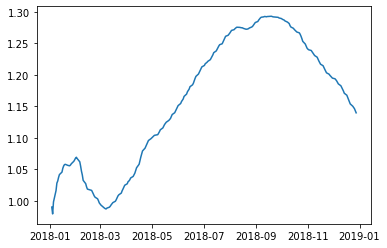

In [115]:
plt.plot(cum)
plt.show()

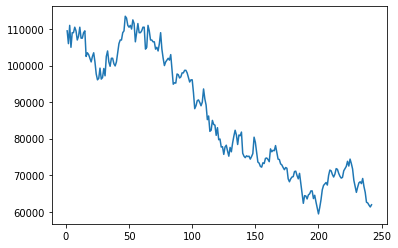

In [45]:
plt.plot(A066570['tdd_clsprc'][1:-1])
plt.show()

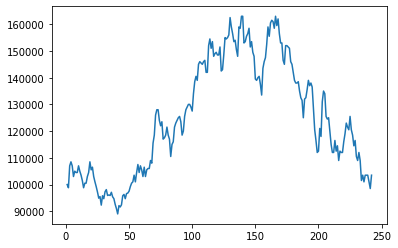

In [25]:
plt.plot(A009150['tdd_clsprc'][1:-1])
plt.show()

포트폴리오 만들어 나가기
1. 만약 order의 칸에 내용이 있으면 기초 내용에 더한다.
 내용이 있는가
  있으면 기초 데이터에 있는 내용인가 
2. 만약 order의 칸에 내용이 없으면 전의 값을 받는다.

In [13]:
import pandas as pd
import requests
import json
from datetime import datetime, timedelta
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import stockprice_getter
import finance_util
import numpy_financial as npf


class backtester():
    """
    order와 data를 받아서 backtest를 돌린다.
    order, data : input이면서 instance 변수.
    portfolio, cash_expense, portfolio_value, porfolio_growth, stocks_return, portfolio_return, irr_return, cum_return :
    instance 내부에서 만드는 변수
    """
    def __init__(self, order):
        self.order = order
        fromdate = self.order.index[0].strftime('%Y%m%d')
        todate = self.order.index[-1].strftime('%Y%m%d')
        self.data = dict()
        priceobj = stockprice_getter.stockprice_getter()
        for stock in order.columns:
            self.data[stock] = priceobj.get_stock_price(stock, fromdate, todate)         


    def get_portfolio(self):
        order_tmp = self.order.copy()
        for col in order_tmp.columns:
            new = []
            for idx in range(len(order_tmp[col])):
                new.append(sum(order_tmp[col][:idx + 1]))
            order_tmp[col] = new
        self.portfolio = order_tmp

        return self.portfolio

    def get_cash_expense(self):
        order_tmp = self.order.copy()
        data_tmp = self.data.copy()
        close_price_list = []
        for code in order_tmp.columns:
            close_prices = list(data_tmp[code]['tdd_clsprc'])
            close_price_list.append(close_prices)
        df_close = pd.DataFrame(close_price_list).T

        cash_expense = []
        for i in range(len(order_tmp)):
            stocks = np.array(order_tmp.iloc[i])
            prices = np.array(df_close.iloc[i])
            cash = stocks.dot(prices)
            cash_expense.append(cash)

        self.cash_expense = pd.DataFrame(cash_expense, index=order_tmp.index, columns=['cash_expense'])

        return self.cash_expense

    def get_portfolio_value(self):
        order_tmp = self.order.copy()
        data_tmp = self.data.copy()
        portfolio = self.get_portfolio()
        close_price_list = []
        for code in portfolio.columns:
            close_prices = list(data_tmp[code]['tdd_clsprc'])
            close_price_list.append(close_prices)
        df_close = pd.DataFrame(close_price_list).T

        value_list = []
        for i in range(len(portfolio)):
            stocks = np.array(portfolio.iloc[i])
            prices = np.array(df_close.iloc[i])
            value = stocks.dot(prices)
            value_list.append(value)
        self.portfolio_value = pd.DataFrame(value_list, index=order_tmp.index, columns=['portfolio_value'])

        return self.portfolio_value

    def get_porfolio_growth(self):
        order_tmp = self.order.copy()
        portfolio_value = self.get_portfolio_value()
        shift1 = portfolio_value['portfolio_value'].shift(1)
        shift0 = portfolio_value['portfolio_value']
        portfolio_growth = pd.DataFrame(index=portfolio_value.index, columns=['portfolio_growth'])
        for i in range(len(portfolio_value)):
            portfolio_growth.iloc[i, 0] = shift0[i] / shift1[i]
        portfolio_growth = (portfolio_growth - 1) * 100
        self.portfolio_growth = portfolio_growth

        return self.portfolio_growth

    def get_stocks_return(self):
        order_tmp = self.order.copy()
        data_tmp = self.data.copy()
        stocks_return_list = []
        for code in order_tmp.columns:
            stock = data_tmp[code]
            return_stock = stock['tdd_clsprc'] / stock['tdd_clsprc'].shift(1)
            return_stock = (return_stock - 1) * 100
            stocks_return_list.append(return_stock)

        stocks_return = pd.DataFrame(stocks_return_list).T

        stocks_return.columns = finance_util.naming_return(order_tmp.columns)
        stocks_return.index = order_tmp.index
        self.stocks_return = stocks_return

        return self.stocks_return
    

    def get_portfolio_return(self):
        order_tmp = self.order.copy()
        portfolio = self.get_portfolio()
        df_return = self.get_stocks_return()

        wgt_return_list = [np.nan]
        for i in range(1, len(portfolio.index)):
            sum_stocks = np.array([portfolio.iloc[i]]).sum()
            wgt = np.array(portfolio.iloc[i]) / sum_stocks
            returns = np.array(df_return.iloc[i])
            wgt_return = wgt.dot(returns)
            wgt_return_list.append(wgt_return)

        self.portfolio_return = pd.DataFrame(wgt_return_list, index=order_tmp.index, columns=['portfolio_return'])

        return self.portfolio_return

    def get_irr_return(self):
        order_tmp = self.order.copy()
        portfolio_value = self.get_portfolio_value()
        cash_expense = self.get_cash_expense()
        irr_list = []
        irr_return = []
        for idx, val in enumerate(list(portfolio_value['portfolio_value'])):
            money = cash_expense['cash_expense'][idx]
            irr_list.append(-money)
            return_measure = npf.irr(irr_list[:-1] + [irr_list[-1] + val])
            irr_return.append(return_measure)

        self.irr_return = pd.DataFrame(irr_return, index=order_tmp.index, columns=['irr_return'])

        return self.irr_return

    def get_cum_return(self):
        order_tmp = self.order.copy()
        irr = self.get_irr_return() + 1
        cum_return = [np.nan]
        for i in range(2, len(irr) + 1):
            cum_return.append(finance_util.seq_mul(list(irr['irr_return'])[1:i]))

        self.cum_return = pd.DataFrame(cum_return, index=order_tmp.index, columns=['cum_return'])

        return self.cum_return

    def run(self):
        """
        portfolio, cash_expense, portfolio_value, portfolio_growth, stocks_return, portfolio_return, irr_return, cum_return
        이 모든 정보를 다 얻는 것.
        """

        portfolio = self.get_portfolio()
        cash_expense = self.get_cash_expense()
        stocks_return = self.get_stocks_return()
        portfolio_value = self.get_portfolio_value()
        portfolio_return = self.get_portfolio_return()
        portfolio_growth = self.get_porfolio_growth()
        irr_return = self.get_irr_return()
        cum_return = self.get_cum_return()

        self.summary = pd.concat([portfolio, cash_expense, stocks_return, portfolio_value,
                                  portfolio_return, portfolio_growth, irr_return, cum_return], axis=1)

        return self.summary


if __name__ == '__main__':
    priceobj = stockprice_getter.stockprice_getter()
    A066570 = priceobj.get_stock_price('A066570', '20180101', '20190101')
    A009150 = priceobj.get_stock_price('A009150', '20180101', '20190101')
    data = {'A066570': A066570, 'A009150': A009150}
    order = pd.DataFrame(index=pd.to_datetime(A066570['trd_dd']))
    elec_buy = []
    for i in range(1, 13):
        for date in order.index[::-1]:
            if date.month == i:
                elec_buy.append(date)
                break
    mecha_buy = []
    for i in range(1, 13):
        for date in order.index:
            if date.month == i:
                mecha_buy.append(date)
                break
    order['A066570'] = 0
    for idx, day in enumerate(elec_buy):
        order.loc[day, 'A066570'] = idx + 1
    order['A009150'] = 0
    for idx, day in enumerate(mecha_buy):
        order.loc[day, 'A009150'] = idx + 1
    order.sort_values(['trd_dd'], inplace=True)
    order.index.rename('date', inplace=True)

    backtester = backtester(order)
    backtester.run()

주식 크롤러 작동
OTP정보 로드 중
OTP정보 로드 완료
주식 크롤러 작동
OTP정보 로드 중
OTP정보 로드 완료
{'A066570':         trd_dd  tdd_clsprc fluc_tp tdd_cmpr acc_trdvol       acc_trdval  \
0   2018-01-02      109500       1    3,500    948,226  103,093,671,000   
1   2018-01-03      109500       3        0    627,983   68,386,930,786   
2   2018-01-04      106000       2    3,500    977,691  104,959,413,400   
3   2018-01-05      111000       1    5,000    883,832   97,229,450,500   
4   2018-01-08      105000       2    6,000  2,480,029  264,241,769,000   
..         ...         ...     ...      ...        ...              ...   
239 2018-12-21       62400       2      200    829,833   51,736,980,600   
240 2018-12-24       61800       2      600    513,348   31,731,223,900   
241 2018-12-26       61300       2      500    453,037   27,737,578,100   
242 2018-12-27       61900       1      600    562,848   35,158,643,900   
243 2018-12-28       62300       1      400    464,747   29,137,707,700   

    tdd_opnprc tdd_hg

In [14]:
pricer = stockprice_getter.stockprice_getter()

주식 크롤러 작동
OTP정보 로드 중
OTP정보 로드 완료


In [15]:
price = pricer.get_stock_price('A005930', '20150101', '20200101')

In [16]:
price

,trd_dd,tdd_clsprc,fluc_tp,tdd_cmpr,acc_trdvol,acc_trdval,tdd_opnprc,tdd_hgprc,tdd_lwprc,mktcap,list_shrs,short_code,codeName
0,2015-01-02,1330000,1,"3,000","175,499","230,643,147,000","1,340,000","1,340,000","1,327,000","195,908,118","147,299,337",A005930,삼성전자
1,2015-01-05,1333000,1,"3,000","202,790","269,329,467,000","1,336,000","1,336,000","1,313,000","196,350,016","147,299,337",A005930,삼성전자
2,2015-01-06,1295000,2,"38,000","304,710","396,554,491,100","1,315,000","1,317,000","1,288,000","190,752,641","147,299,337",A005930,삼성전자
3,2015-01-07,1307000,1,"12,000","286,455","372,136,331,000","1,294,000","1,311,000","1,282,000","192,520,233","147,299,337",A005930,삼성전자
4,2015-01-08,1314000,1,"7,000","289,552","376,898,288,000","1,339,000","1,339,000","1,310,000","193,551,329","147,299,337",A005930,삼성전자
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,2019-12-23,55500,2,500,"9,839,252","546,622,686,828","56,100","56,400","55,100","331,322,932","5,969,782,550",A005930,삼성전자
1223,2019-12-24,55000,2,500,"11,868,463","655,144,129,100","55,600","55,700","54,800","328,338,040","5,969,782,550",A005930,삼성전자
1224,2019-12-26,55400,1,400,"9,645,034","530,104,740,900","54,700","55,400","54,400","330,725,953","5,969,782,550",A005930,삼성전자
1225,2019-12-27,56500,1,"1,100","12,313,056","692,415,134,500","55,700","56,900","55,500","337,292,714","5,969,782,550",A005930,삼성전자


In [17]:
ret = price['tdd_clsprc'] / price['tdd_clsprc'].shift(1)

In [18]:
ret

0            NaN
1       1.002256
2       0.971493
3       1.009266
4       1.005356
          ...   
1222    0.991071
1223    0.990991
1224    1.007273
1225    1.019856
1226    0.987611
Name: tdd_clsprc, Length: 1227, dtype: float64

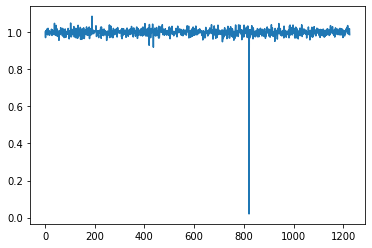

In [19]:
plt.plot(ret)
plt.show()

In [30]:
len(ret[ret < 0.7])

1

In [29]:
ret[ret < 0.7]

821    0.019585
Name: tdd_clsprc, dtype: float64